In [1]:
# 1. import module
## utils
import random
import os
from random import sample
import numpy as np
import pickle
import time
import sys
import copy
import argparse
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, precision_recall_curve
from scipy.ndimage import gaussian_filter
from skimage import morphology
from skimage.segmentation import mark_boundaries
import seaborn as sns


## torch module
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

## eff model
from efficient_modified import EfficientNetModified

## mvtec datasets
import datasets.mvtec as mvtec

## filter warnings
warnings.filterwarnings('ignore')

In [2]:
# 2. choose device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(f"PyTorch Version: {torch.__version__}")
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")

PyTorch Version: 1.9.0+cu111
GPU is available


In [3]:
# 3. functions
# def parse_args():
#     parser = argparse.ArgumentParser('PaDiM Parameters')
#     parser.add_argument('-d', '--data_path', type=str, required=True, help='mvtec data location')
#     parser.add_argument('-s', '--save_path', type=str, required=True, help='inference model & data location')
#     parser.add_argument('-a', '--arch', type=str, choices=['b0', 'b1', 'b4', 'b7'], default='b4')
#     parser.add_argument('-b', '--batch_size', type=int, default=32)
#     parser.add_argument('--training', action='store_true')
#     parser.add_argument('--seed', type=int, default=1024)
#     parser.add_argument('--resize', type=int, default=256)
#     parser.add_argument('--cropsize', type=int, default=224)
#     parser.add_argument('--model_print', action='store_true')
#     parser.add_argument('--img_print', action='store_true')
    
#     return parser.parse_args()
    # epoch, random_select size

def create_seed(filters):
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    if use_cuda:
        torch.cuda.manual_seed_all(args.seed)

def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()

    s = int(H1/H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)

    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)

    return z

def show_feat_list(model, size=(1, 3, 224, 224)):
    sample_inputs = torch.zeros(size)
    feat_list = model.extract_entire_features(sample_inputs)
    for i, feat in enumerate(feat_list, 0):
        print(i, feat.shape)

def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    return img.mul_(std).add_(mean)    

def show_sample_images(dataloader, n, class_name):
    x, _, _ = next(iter(dataloader))

    if x == None:
        print('[error] dataloader empty!')
        return
    
    if n > args.batch_size:
        print('[error] n exceeds batch size!')
        return 
    
    rows = n//4
    cols = 4
    axes = []
    fig = plt.figure(figsize=(20, 20), dpi=200)

    for i in range(rows*cols):
        axes.append(fig.add_subplot(rows, cols, i+1))
        title = '%s subplot %d' % (class_name, i)
        axes[-1].set_title(title)
        axes[-1].imshow(denormalize(x[i].permute(1, 2, 0)))

    fig.tight_layout()
    pic_save_path = os.path.join(args.save_path, 'sample_%s' % (class_name))
    fig.savefig(pic_save_path, dpi=200)
    plt.show()

def calc_covinv(embedding_vectors, H, W, C):
      for i in range(H * W):
        yield np.linalg.inv(np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * np.identity(C))

def plot_fig(test_img, scores, gts, threshold, save_dir, class_name):
    num = len(scores)
    vmax = scores.max()
    vmin = scores.min()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(num):
        img = test_img[i]
        img = (((img.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8) # denormalize
        gt = gts[i].transpose(1, 2, 0).squeeze()
        heat_map = scores[i]
        normalized_heat_map = (heat_map - vmin) / (vmax - vmin)
        mask = scores[i]
        mask[mask > threshold] = 1
        mask[mask <= threshold] = 0
        kernel = morphology.disk(2)
        mask = morphology.opening(mask, kernel)
        mask *= 255
        vis_img = mark_boundaries(img, mask, color=(1, 0, 0), mode='thick')
        fig_img, ax_img = plt.subplots(1, 5, figsize=(12, 3))
        fig_img.subplots_adjust(right=0.9)
        
        # Additional information
        img_threshold = img_thresholds[np.argmin(distances)]
        img_threshold = 0.17
        predicted_label = (img_scores[i] > img_threshold).astype(int)
        true_label = gt_list[i]

        title = 'Sample {}\nImg_threshold: {:.3f}, Img_score: {:.3f}, Predicted: {}, True: {}, Pixel_threshold: {:.3f}'.format(
            i, img_threshold, img_scores[i], predicted_label, true_label, threshold)
        fig_img.suptitle(title)
        
        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)
        ax_img[0].imshow(img)
        ax_img[0].title.set_text('Image')
        ax_img[1].imshow(gt, cmap='gray')
        ax_img[1].title.set_text('GroundTruth')
        ax_img[2].imshow(img, cmap='gray', interpolation='none')
        ax_img[2].imshow(normalized_heat_map, cmap='jet', alpha=0.5, interpolation = 'none', vmin = 0, vmax = 1)
        ax_img[2].title.set_text('Predicted heat map')
        ax_img[3].imshow(mask, cmap='gray')
        ax_img[3].title.set_text('Predicted mask')
        ax_img[4].imshow(vis_img)
        ax_img[4].title.set_text('Segmentation result')
        
        left = 0.92
        bottom = 0.15
        width = 0.015
        height = 1 - 2 * bottom
        rect = [left, bottom, width, height]
        cbar_ax = fig_img.add_axes(rect)
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        cb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), cax=cbar_ax)
        cb.ax.tick_params(labelsize=8)
        font = {
            'family': 'serif',
            'color': 'black',
            'weight': 'normal',
            'size': 8,
        }
        cb.set_label('Anomaly Score', fontdict=font)
        
       
        fig_img.savefig(os.path.join(save_dir, class_name + '_{}'.format(i)), dpi=100)
        plt.close()

In [4]:
def get_args(data_path, save_path, arch='b4', batch_size=32, training=False, seed=1024, resize=224, model_print=False, img_print=False):
    class Args:
        pass

    args = Args()
    args.data_path = data_path
    args.save_path = save_path
    args.arch = arch
    args.batch_size = batch_size
    args.training = training
    args.seed = seed
    args.resize = resize
#     args.cropsize = cropsize
    args.model_print = model_print
    args.img_print = img_print

    return args

if __name__ == '__main__':
    data_path = 'full_unit/'
    save_path = 'result'
    arch = 'b4' #can be b0,b1,b4,b7
    batch_size = 32
    training = True
    seed = 1024
    resize = 224
#     cropsize = 224
    model_print = True
    img_print = True
    
    args = get_args(data_path, save_path, arch, batch_size, training, seed, resize, model_print, img_print)

    name = 'efficientnet-{}'.format(args.arch)
    eff_model = EfficientNetModified.from_pretrained(name)

    if args.model_print:
        print(eff_model)

Loaded pretrained weights for efficientnet-b4
EfficientNetModified(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv

In [5]:
# make directory for saving data
os.makedirs(os.path.join(args.save_path, 'model_pkl_%s' % name), exist_ok=True)


if args.arch == 'b0':
    block_num = torch.tensor([3, 5, 11]) # b0 
    filters = (24 + 40 + 112) # 176
elif args.arch == 'b1':
    # block_num = torch.tensor([3, 6, 9]) # b1 first, 24 + 40 + 80
    # block_num = torch.tensor([4, 7, 13]) # b1 medium 24 + 40 + 112
    block_num = torch.tensor([5, 8, 16]) # b1 last 24 + 40 + 112
    filters = (24 + 40 + 112) # 176
elif args.arch == 'b4':
    # block_num = torch.tensor([3, 7, 11]) # b4 (32 + 56 + 112)
    block_num = torch.tensor([3, 7, 17]) # b4 (32 + 56 + 160)
    # block_num = torch.tensor([5, 9, 13]) # (32 + 56 + 112)
    # block_num = torch.tensor([5, 9, 20]) # b4 (32 + 56 + 160)
    # block_num = torch.tensor([6, 10, 22]) # b4 (32 + 56 + 160)
    filters = (32 + 56 + 160) # 248
elif args.arch == 'b7':
    block_num = torch.tensor([11, 18, 38]) # b7 (48 + 80 + 224) # last
    # block_num = torch.tensor([5, 12, 29]) # b7 (48 + 80 + 224) # first
    # block_num = torch.tensor([8, 15, 33]) # medium
    filters = (48 + 80 + 224) # 352

'''
The number of filters is so small that I want to take the entire filter, not randomly. 
So I'm going to delete the random code this time.
'''
create_seed(filters)

# model attach to device
eff_model.to(device)

EfficientNetModified(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, ke

training:  True


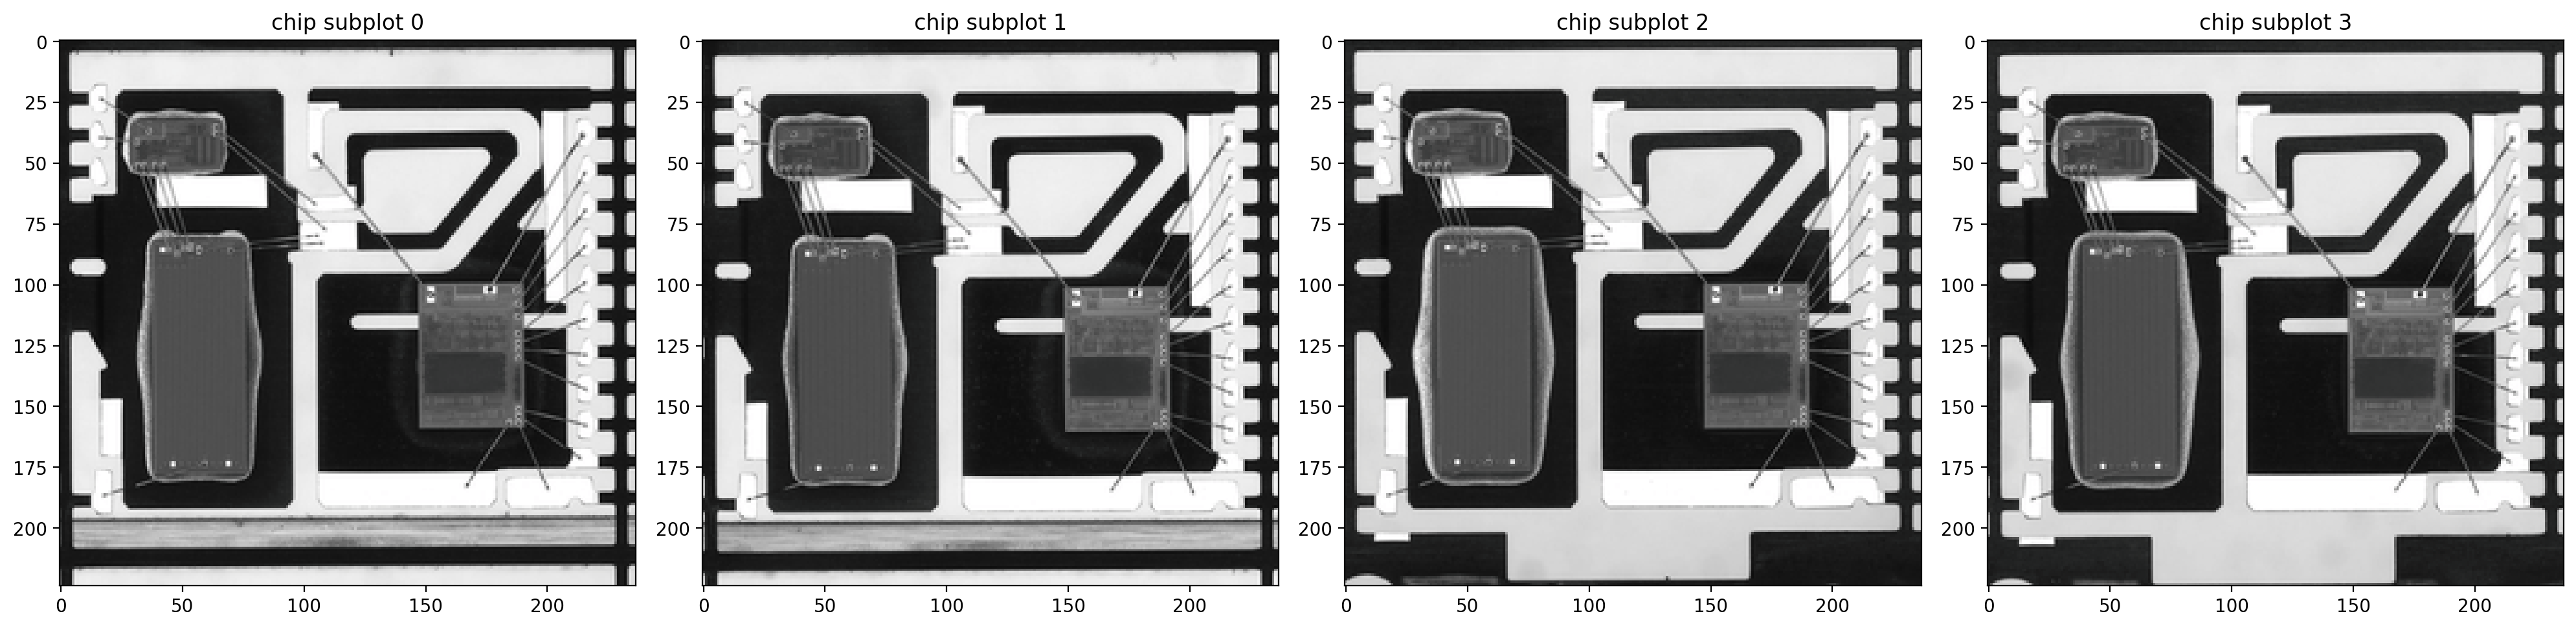

| feature extraction | train | chip |: 100%|███████████████████████████████████████████| 18/18 [00:19<00:00,  1.09s/it]


RuntimeError: shape '[571, 32, -1, 28, 30]' is invalid for input of size 59347456

In [6]:
#train
print('training: ', args.training)

class_name = 'chip'
train_dataset = mvtec.MVTecDataset(args.data_path, class_name=class_name, is_train=True)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, pin_memory=True)
# test_dataset = mvtec.MVTecDataset(args.data_path, class_name=class_name, is_train=False)
# test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, pin_memory=True)

train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])
# test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

# plt.show vscode not work, so save fig
if args.img_print:
    show_sample_images(train_dataloader, args.batch_size // 8, class_name)

# model_path
train_feature_filepath = os.path.join(args.save_path, 'model_pkl_%s' % name, 'train_%s.pkl' % class_name)

if args.training:
    if os.path.exists(train_feature_filepath):
        os.remove(train_feature_filepath)

    eff_model.eval()
    for (x, _, _) in tqdm(train_dataloader, '| feature extraction | train | %s |' % class_name):
        with torch.no_grad():
            feats = eff_model.extract_features(x.to(device), block_num.to(device))

        # If you want to see the shape of the feature...
        # for i, feat in enumerate(feats):
        #     print("layer {} feature's shape: {}".format(i, feat.shape))

        for k, v in zip(train_outputs.keys(), feats):
            train_outputs[k].append(v.cpu().detach())

    for k, v in train_outputs.items():
        train_outputs[k] = torch.cat(v, 0)

    embedding_vectors = train_outputs['layer1']
    for layer_name in ['layer2', 'layer3']:
        embedding_vectors = embedding_concat(embedding_vectors, train_outputs[layer_name])

    B, C, H, W = embedding_vectors.size()
    print("embedding vector's size: {}, {}, {}, {}".format(B, C, H, W))

    embedding_vectors = embedding_vectors.view(B, C, H * W)
    mean = torch.mean(embedding_vectors, dim=0).numpy()
    cov_inv = torch.zeros(C, C, H * W).numpy()
    I = np.identity(C)
    
    # It's done with generator, but it doesn't matter what you do because there's not much memory difference.
    # cc = calc_covinv(embedding_vectors, H, W, C)
    # for i, value in enumerate(cc):
    #     cov_inv[:, :, i] = value 

    for i in range(H * W):
        cov_inv[:, :, i] = np.linalg.inv(np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I)
    # save learned distribution
    train_outputs = [mean, cov_inv]
    print("mean shape: ", mean.shape)
    print("cov_inv shape: ", cov_inv.shape)
    with open(train_feature_filepath, 'wb') as f:
        pickle.dump(train_outputs, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    if not os.path.exists(train_feature_filepath):
        print('train set feature file not exists: {}'.format(train_feature_filepath))
    else:
        print('load train set feat file from %s' % train_feature_filepath)
        with open(train_feature_filepath, 'rb') as f:
            train_outputs = pickle.load(f)

In [ ]:
#test
mean = torch.Tensor(train_outputs[0]).to(device)
cov_inv = torch.Tensor(train_outputs[1]).to(device)

test_dataset = mvtec.MVTecDataset(args.data_path, class_name=class_name, is_train=False)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, pin_memory=True)

test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

gt_list = []
gt_mask_list = []
test_imgs = []
total_roc_auc = []
total_pixel_roc_auc = []

# If you pass without picking a feature
# Depending on eval, the method of calculating bn, dropout etc varies.
eff_model.eval()

inference_start = time.time()

for (x, y, mask) in tqdm(test_dataloader, '| feature extraction | test | %s |' % class_name):
    test_imgs.extend(x.cpu().detach().numpy())
    gt_list.extend(y.cpu().detach().numpy())
    gt_mask_list.extend(mask.cpu().detach().numpy())

    with torch.no_grad():
        feats = eff_model.extract_features(x.to(device), block_num.to(device))

    for k, v in zip(test_outputs.keys(), feats):
        test_outputs[k].append(v.cpu().detach())

for k, v in test_outputs.items():
    test_outputs[k] = torch.cat(v, 0)

embedding_vectors = test_outputs['layer1']
for layer_name in ['layer2', 'layer3']:
    embedding_vectors = embedding_concat(embedding_vectors, test_outputs[layer_name])


B, C, H, W = embedding_vectors.size()
embedding_vectors = embedding_vectors.view(B, C, H * W).to(device)


dist_list = torch.zeros(size=(H*W, B))
for i in range(H*W):
    delta = embedding_vectors[:, :, i] - mean[:, i]
    m_dist = torch.sqrt(torch.diag(torch.mm(torch.mm(delta, cov_inv[:, :, i]), delta.t())))
    dist_list[i] = m_dist

dist_list = dist_list.transpose(1, 0).view(B, H, W)
score_map = F.interpolate(dist_list.unsqueeze(1), size=x.size(2), mode='bilinear', align_corners=False).squeeze().cpu().numpy()

for i in range(score_map.shape[0]):
    score_map[i] = gaussian_filter(score_map[i], sigma=4)

inference_time = (time.time() - inference_start)/len(test_dataset)
print('{} inference time per sample: {:.3f}'.format(class_name, inference_time))

# Normalization
max_score = score_map.max()
min_score = score_map.min()
scores = (score_map - min_score) / (max_score - min_score)
print('scores size: ', scores.shape)

#plot ROCAUC charts
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig_img_rocauc = ax[0]
fig_pixel_rocauc = ax[1]

# calculate image-level ROC AUC score
img_scores = scores.reshape(scores.shape[0], -1).max(axis=1) #max of all pixel scores
print('img_scores size: ', img_scores.shape)
print('number of img_thresholds if drop_intermediate = False: ', len(np.unique(img_scores)) + 1)
gt_list = np.asarray(gt_list)
fpr, tpr, img_thresholds = roc_curve(gt_list, img_scores)
img_roc_auc = roc_auc_score(gt_list, img_scores)
total_roc_auc.append(img_roc_auc)
fig_img_rocauc.plot(fpr, tpr, label='%s img_ROCAUC: %.3f' % (class_name, img_roc_auc))
print('gt_list:', gt_list)
print('img_scores:', img_scores)
print('img_thresholds:', img_thresholds )
print('img_thresholds if drop_intermediate = False:', roc_curve(gt_list, img_scores, drop_intermediate=False)[2])
print('image ROCAUC: %.3f' % (img_roc_auc))

# get optimal threshold based Label
distances = (tpr - 1.) ** 2 + fpr ** 2
img_threshold = img_thresholds[np.argmin(distances)]
img_threshold = 0.17

gt_mask = np.asarray(gt_mask_list)
precision, recall, thresholds = precision_recall_curve(gt_mask.flatten(), scores.flatten())
print('thresholds: ', thresholds)
print('thresholds size: ', thresholds.shape)
a = 2 * precision * recall
b = precision + recall
f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
threshold = thresholds[np.argmax(f1)]
threshold = 0.065

# label, mask two types threshold 
print('label based threshold: {:.3f}, pixel based threshold: {:.3f}'.format(img_threshold, threshold))

# calculate per-pixel level ROCAUC
fpr, tpr, _ = roc_curve(gt_mask.flatten(), scores.flatten())
per_pixel_rocauc = roc_auc_score(gt_mask.flatten(), scores.flatten())
total_pixel_roc_auc.append(per_pixel_rocauc)
fig_pixel_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (class_name, per_pixel_rocauc))
print('pixel ROCAUC: %.3f' % (per_pixel_rocauc))

print('Average ROCAUC: %.3f' % np.mean(total_roc_auc))
fig_img_rocauc.title.set_text('Average image ROCAUC: %.3f' % np.mean(total_roc_auc))
fig_img_rocauc.legend(loc="lower right")
print('Average pixel ROCUAC: %.3f' % np.mean(total_pixel_roc_auc))
fig_pixel_rocauc.title.set_text('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
fig_pixel_rocauc.legend(loc="lower right")

save_dir = args.save_path + '/' + f'pictures_efficientnet-{args.arch}'
os.makedirs(save_dir, exist_ok=True)

fig.tight_layout()
fig.savefig(os.path.join(args.save_path, '%s_lst_roc_curve.png' % name), dpi=100)

# Calculate confusion matrix
predicted_labels = (img_scores > img_threshold).astype(int)
confusion_mat = confusion_matrix(gt_list.flatten(), predicted_labels.flatten())

# Plot confusion matrix
class_names = ['Normal', 'Anomaly']
sns.set()
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(os.path.join(save_dir, f'{class_name}_confusion_matrix.png'))
plt.close()

# class, image ROCAUC, pixel ROCAUC, inference_time
with open(args.save_path + '/' + f'efficientnet-{args.arch}-lst.txt', "a") as f:
    f.write('{}-{:.3f}-{:.3f}-{:.3f}\n'.format(class_name, img_roc_auc, per_pixel_rocauc, inference_time))

In [ ]:
#plot test images and detection
plot_fig(test_imgs, scores, gt_mask_list, threshold, save_dir, class_name)